In [17]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random as rand
np.set_printoptions(suppress=True)

x_digit = idx2numpy.convert_from_file('data/train-images-idx3-ubyte')
y_digit = idx2numpy.convert_from_file('data/train-labels-idx1-ubyte')

print(x_digit.shape, y_digit.shape)

(60000, 28, 28) (60000,)


In [18]:
### Generate train and test data using mnist set with NUM_SIZE digits
NUM_SIZE = 6

image_dict = [[] for i in range(10)]
for digit,image in zip(y_digit, x_digit):
    image_dict[digit].append(image)


def gen_test_data(num_data):
    x_data, y_data = np.zeros((num_data, NUM_SIZE, 28, 28)), np.zeros((num_data, NUM_SIZE))
    for i in range(num_data):
        for k in range(NUM_SIZE):
            rand_digit = rand.randint(0,9)
            rand_img = rand.choice(image_dict[rand_digit])
            y_data[i,k] = rand_digit
            x_data[i,k] = rand_img
    return x_data.reshape(num_data, NUM_SIZE * 28, -1), y_data

x_train, y_train = gen_test_data(30000)
x_test, y_test = gen_test_data(2000)
x_test_check = x_test
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(30000, 168, 28) (30000, 6) (2000, 168, 28) (2000, 6)


In [19]:
x_train = x_train.T.reshape(-1, 30000)
x_test = x_test.T.reshape(-1,2000)
y_test = tf.one_hot(y_test, 10).numpy().reshape(2000,-1).T
y_train = tf.one_hot(y_train, 10).numpy().reshape(30000,-1).T
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(type(x_train), type(x_test), type(y_train), type(y_test))

(4704, 30000) (60, 30000) (4704, 2000) (60, 2000)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [32]:
layer_dims = [x_train.shape[0], 1024, 10 * NUM_SIZE]

def init_params():
    weights = {}
    biases = {}
    for l in range(1, len(layer_dims)):
        weights[l] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01;
        biases[l] = np.zeros((layer_dims[l],1))
    return weights,biases

In [60]:
def relu(z):
    return np.maximum(0,z)

# 20 x m input
def softmax(z):
    return tf.nn.softmax(z.reshape(6,10,-1), axis=1).numpy().reshape(60,-1)
    

#  20 x m vs 20 x m
def compute_cost(Y_expected, Y_actual):
    #print("\nExpected \n",Y_expected)
    #print("\n Actual ", Y_actual)
    m = Y_expected.shape[1]
    return -6/m * np.sum(np.multiply(Y_expected, np.log(Y_actual)))

def forward_prop(X, W, B):
    Z = {}
    A = {0: X}
    cost = 0
    for l in range (1, len(layer_dims)):
        Z[l] = np.dot(W[l] , A[l-1]) + B[l]
        if l == len(layer_dims) -1:
            A[l] = softmax(Z[l])
        else:
            A[l] = relu(Z[l])
    return Z, A

def calc_accuracy(Y_expected, Y_actual):
    Y_actual = Y_actual.astype(int)
    Y_expected = Y_expected.astype(int)
    return (1.0/6.0) * np.sum(np.bitwise_and(Y_expected, Y_actual))/Y_expected.shape[1]

def backward_prop_update_weights(Z, A, Y, W, B, learning_rate):
    m = Y.shape[1]
    #derivation flowing into the activation function (starts with 1 because dL/dL = 1)
    propogated_derv = 1
    activation_derv = 0
    
    for l in range(len(layer_dims) -1, 0 , -1):
        if l == len(layer_dims)-1:
            ##softmax derivative (Y_actual - Y_expected)
            activation_derv = A[l] - Y
        else:
            ##relu derivative
            activation_derv = (Z[l] > 0) * 1
            
        dZ = np.multiply(propogated_derv, activation_derv)
        dW = 1/m * np.dot(dZ, A[l-1].T)
        dB = 1/m * (np.sum(dZ,axis=1, keepdims=True))
        W[l] = W[l] - learning_rate * dW
        B[l] = B[l] - learning_rate * dB
        propogated_derv = np.dot(W[l].T, dZ)
    return W, B

def train(X, Y, numitrs, learning_rate, batch_size):
    W, B = init_params()
    lr = 0
    for itrs in range(numitrs):
        print(itrs)
        for batch in range(X.shape[1]//batch_size):
            if itrs <=12: lr = 0.00007
            else: lr = learning_rate
            #print("Processing batch " + str(batch*batch_size) + " to " + str((batch+1) * batch_size))
            bx = X[:, batch*batch_size: (batch + 1) * batch_size]
            by = Y[:, batch*batch_size: (batch + 1) * batch_size]
            Z, A = forward_prop(bx, W, B)
            W, B = backward_prop_update_weights(Z , A, by, W, B, lr)
        l = len(layer_dims) -1
        cost = compute_cost(by, A[l])
        accuracy = calc_accuracy(by, (A[l] > 0.5) * 1)
        print("Cost :" + str(cost) + " Accuracy: " + str(accuracy) + " lr = " + str(lr))
    return W, B

def predict(X, W, B):
    Z, A = forward_prop(X, W, B)
    return A[len(layer_dims)-1]

In [ ]:
W , B = train(x_train, y_train, 100, 0.00002, 1000)

0
Cost :211.61178252417292 Accuracy: 0.3118333333333333 lr = 7e-05
1
Cost :132.2748237231843 Accuracy: 0.4498333333333333 lr = 7e-05
2
Cost :100.15796760603223 Accuracy: 0.5331666666666667 lr = 7e-05
3
Cost :83.43479552373378 Accuracy: 0.5856666666666667 lr = 7e-05
4
Cost :72.5466730929213 Accuracy: 0.6221666666666666 lr = 7e-05
5
Cost :64.83054718757158 Accuracy: 0.6518333333333333 lr = 7e-05
6
Cost :58.9809805517025 Accuracy: 0.674 lr = 7e-05
7
Cost :54.40549115648135 Accuracy: 0.6908333333333333 lr = 7e-05
8
Cost :50.71733361475955 Accuracy: 0.7061666666666666 lr = 7e-05
9
Cost :47.71909895034713 Accuracy: 0.7208333333333332 lr = 7e-05
10
Cost :45.281441062813755 Accuracy: 0.7316666666666666 lr = 7e-05
11
Cost :43.24144793442301 Accuracy: 0.7418333333333332 lr = 7e-05
12
Cost :41.43537681103147 Accuracy: 0.749 lr = 7e-05
13
Cost :39.01527096426698 Accuracy: 0.7503333333333333 lr = 2e-05
14
Cost :38.54114351723982 Accuracy: 0.7526666666666666 lr = 2e-05
15
Cost :38.08176873562724 Acc

In [37]:
output = predict(x_test, W, B)
print("Accuracy on test set is " + str(calc_accuracy(y_test, (output > 0.5) * 1.0)))

Accuracy on test set is 0.79825


[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]
(5000, 56, 28)
(56, 28)


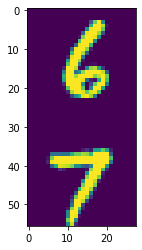

In [572]:
print((output[:,100:101] > 0.5) * 1.0)
test = x_test_check[100:101,:,:].reshape(56,-1)
print(test.shape)
plt.imshow(test)